# PyTorch basics

<a href="https://colab.research.google.com/github/m12sl/dl-hse-2021/blob/master/02-pytorch/homework.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

В этой тетрадке мы познакомимся с общими принципами построения нейронных сетей.

**Цели тетрадки**

1. Знакомство с базовыми слоями PyTorch
1. Практика в построении и обучении сетей

**(повтор) Материалы по pytorch:**

* [PyTorch docs](https://pytorch.org/docs/stable/index.html)
* [Классная статья про pytorch internal](http://blog.ezyang.com/2019/05/pytorch-internals/)

## Prerequirements

```
pip install torch torchvision numpy matplotlib
```

In [1]:
import torch

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter


from torchvision import transforms
from torchvision.datasets import MNIST

import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
writer = SummaryWriter("./check-this/")

fake_loss = 1 / np.arange(1, 100)
for global_step, point in enumerate(fake_loss):
    writer.add_scalar("lossy", point, global_step=global_step)
writer.close()

In [3]:
class Trainer:
    def __init__(self, model, optimizer, train_dataset, val_dataset, batch_size=128):
        self.model = model
        self.optimizer = optimizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset

        self.batch_size = batch_size

        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)
        
        self.global_step = 0
        self.writer = SummaryWriter("./tmp/")
        self.val_losses = []
        self.train_losses = []

    def save_checkpoint(self, path):
        torch.save(self.model.state_dict(), path)

    def train(self, num_epochs):
        model = self.model
        optimizer = self.optimizer
        
        train_loader = DataLoader(self.train_dataset, shuffle=True, pin_memory=True, batch_size=self.batch_size)
        val_loader = DataLoader(self.val_dataset, shuffle=False, pin_memory=True, batch_size=self.batch_size)
        best_loss = float('inf')
        
        for epoch in tqdm(range(num_epochs)):
            model.train()
            for batch in train_loader:
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)
                self.train_losses.append(loss.item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                for k, v in details.items():
                  self.writer.add_scalar(k, v, global_step=self.global_step)
                  self.global_step += 1
            
            model.eval()
            
            
            for batch in val_loader:
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)
                self.val_losses.append(loss.item())
                
            val_loss = np.mean(self.val_losses)        
            if val_loss < best_loss:
                self.save_checkpoint("./best_checkpoint.pth")
                best_loss = val_loss
 
    def plot(self): # добавил для себя, для удобной визуализации
      plt.figure(figsize=(16, 10))
      plt.subplot(2,1,1)
      plt.plot(self.val_losses, label='val sample', color='red')
      plt.ylabel('Loss')
      plt.legend()
      plt.subplot(2,1,2)
      plt.plot(self.train_losses, label='train sample', color='blue')
      plt.ylabel('Loss')
      plt.legend()
      plt.show()

## Hello MNIST

Прежде чем собирать сеть, давайте определим инстансы класса `Dataset`, которые будут возвращать примеры из тренировочной и валидационной выборок.  
С помощью ячейки ниже, мы скачаем датасет [MNIST](http://yann.lecun.com/exdb/mnist/) в текущую директорию и сможем получать примеры из соответствующих объектов.

In [4]:
 transform_to_tensor = transforms.Compose([
     transforms.ToTensor()
 ])

 mnist_train = MNIST(root='./', train=True, download=True, transform=transform_to_tensor)
 mnist_val = MNIST(root='./', train=False, download=True, transform=transform_to_tensor)

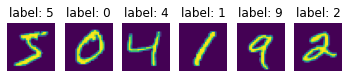

In [5]:
def show_examples(dataset: Dataset, num_examples: int = 4):
    fig, ax = plt.subplots(1, num_examples)
    
    for i in range(num_examples):
        img, label = dataset[i]
        ax[i].imshow(img[0])
        ax[i].set_title(f'label: {label}')
        ax[i].axis('off')
    plt.show()
    
    
show_examples(dataset=mnist_train, num_examples=6)

Я решил воспользоваться классом с предыдущего семинара: 

In [6]:
class VectorSet:
    def __init__(self, train=True):
        self.data = MNIST("./tmp", train=train, download=True)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, item):
        img, label = self.data[item]
        img = np.array(img).astype(np.float32).reshape(-1)
        return dict(
            sample=img,
            label=label,
        )

In [7]:
trainset = VectorSet(train=True)
valset = VectorSet(train=False)

Посмотрим на несколько примеров из тренировочной выборки

## Задание 1 (бонус)
**(0.4 балла, бонус)** Напишите свою версию датасета, который будет читать картинки с диска.  
Подразумевается, что если вы написали свой датасет, то он будет использоваться при обучении вместо дефолтного `MNIST`.  
Вам понадобится архив [Google Drive](https://drive.google.com/file/d/1DOtScRd7la_sJflLgoNa0vFUuhjlVHa7/view?usp=sharing):
- /
    - /train.csv
    - /val.csv
    - /train/{image_name}.png
    - /val/{image_name}.png

CSV файлы содержат название файла и его лейбл: image_name, label.

*Hint 1:* нужно унаследоваться от класса `Dataset` и переопределить методы `__getitem__` и `__len__`.
Первый должен возвращать картинку и ее лейбл, а второй количество примеров в датасете.
(На самом деле второй метод не обязателен для самого датасета, но он необходим для
[семплера](https://pytorch.org/docs/stable/data.html#torch.utils.data.RandomSampler),
который используется даталоадером)
(см. [PyTorch docs](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset),
[PyTorch tutorual](https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html?highlight=dataset))  
*Hint 2:* для работы с картиноками лучше использовать OpenCV: `pip install opencv-python-headless`.
В частности [cv2.imread](https://docs.opencv.org/master/d4/da8/group__imgcodecs.html#ga288b8b3da0892bd651fce07b3bbd3a56).  
*Hint 3:* обратите особое внимание на то, что возвращает функция `cv2.imread`

In [18]:
#!pip install cv2
import cv2
import pandas as pd

In [17]:
class DatasetMNIST(Dataset):
    def __init__(self, dir:str, is_train=True):
        self.dir = dir # папка, где лежат наши датасеты
        if is_train: # выбираем, что загружать
            self.set = 'train'
        else:
            self.set = 'val'
        self.labels = pd.read_csv(dir+'/' + self.set + '.csv') # загружаем
        

    def __len__(self):
        return len(self.labels) 
    
    def __getitem__(self, index):

        label = self.labels.iloc[index]['label']
        name_img = str(self.labels.iloc[index]['image_name'])

        while len(name_img) < 5:
            name_img = '0' + name_img
                
        path = self.dir + '/' + self.set + '/' + name_img + '.png'
        rgb_img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) # cv2.imread(path) возвращает BGR, a не RGB! http://robocraft.ru/blog/computervision/4025.html

        return dict(sample=torch.tensor(rgb_img, dtype=torch.float64), label=label)

Класс сверху я не тестил, но все проверил 5 раз. Просто я делаю эту дз с рабочего компа, где закрыт доступ к гугл дискам)))

## Задание 2
**(0.3 балла)** Напишите класс MLP сети из 3 линейных слоев, которая будет получать на вход
батч картинок размера [BS, C, H, W]

*Hint 1:* метод `reshape` поможет вытянуть картинку в вектор.  
*Hint 2:* выход должен соответствовать количеству лейблов, то есть 10.  
*Hint 3:* пачка линейных слоев подряд не имеет смысла без нелинейностей между ними.

In [9]:
class CustomMLP(nn.Module):
    def __init__(self,
                 num_pixels_per_img: int = 784,  # hint: 28*28 == 784
                 ):
        super().__init__()
        self.num_pixels_per_img = num_pixels_per_img
        # here you can init layers and stack them with nn.Sequential
        self.layers = nn.Sequential(nn.Linear(num_pixels_per_img, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 64),
                                    nn.ReLU(),
                                    nn.Linear(64, 10)) # ну с таким перцентропом все легко, главное релушки не забывать

        
    def forward(self, x):
        # describe usage of layers here, be careful with input shape
        return self.layers(x)
    
    def compute_all(self, batch): # удобно сделать функцию, в которой вычисляется лосс по пришедшему батчу
        x = batch['sample'] / 255.0
        x = x.reshape(-1, self.num_pixels_per_img) # вытягиваем картинку в вектор
        y = batch['label']
        logits = self.layers(x)
        
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)
        return loss, metrics


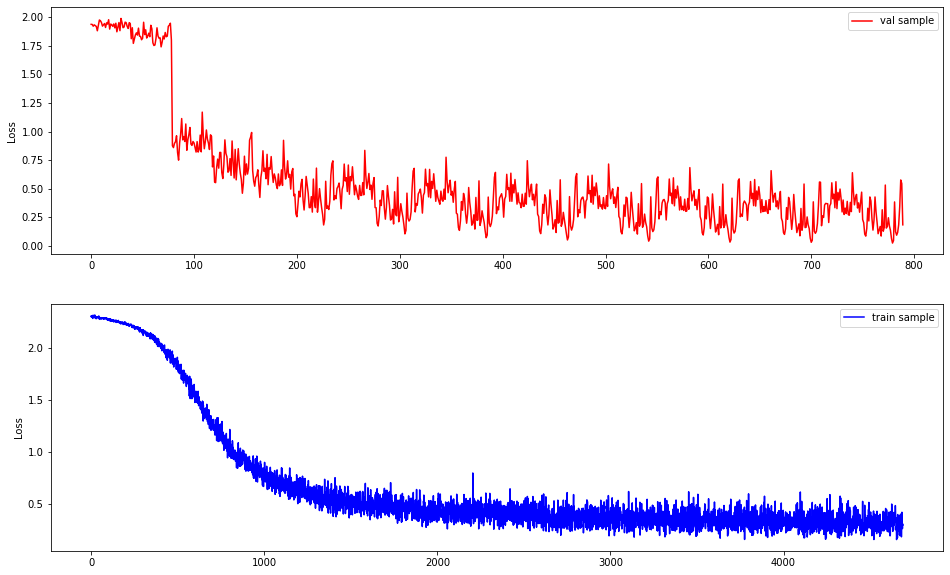

In [10]:
# Как и просилось, давайте сразу тестить!
model = CustomMLP()
opt = optim.SGD(model.parameters(), lr=1e-2)
trainer = Trainer(model, opt, trainset, valset, batch_size=128)

trainer.train(10)

trainer.plot()

## Задание 3
**(0.3 балла)** Напишите класс CNN сети из 3 сверточных слоев.

*Hint 1:* на вход все те же батчи размера [BS, C, H, W]  
*Hint 2:* описание сверточных слоев [PyTorch docs](https://pytorch.org/docs/stable/nn.html#convolution-layers)

In [11]:
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Conv2d(1, 4, kernel_size=3), # сначала обычную свертку
                                    nn.ReLU(), # релу 
                                    nn.MaxPool2d(2), # макс пуллим
                                    nn.Conv2d(4, 16, kernel_size=3), # увеличим еще число наших каналов
                                    nn.ReLU(), # релу
                                    nn.MaxPool2d(2), # макспуллим
                                    nn.Conv2d(16, 64, kernel_size=3), # и еще раз свертку 
                                    nn.ReLU(), # релулим
                                    nn.MaxPool2d(2), # макспулим 
                                    nn.Flatten()) # вытягиваем

    def forward(self, x):
        self.layers(x)
    
    def compute_all(self, batch):
        x = batch['sample'] / 255.0 # так как при загрузке датасета мы не делили его на 255, давайте это делать тут
        x = x.reshape(-1, 1, 28, 28) # [bs, c, h, w]
        y = batch['label']
        logits = self.layers(x)
        
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)
        return loss, metrics

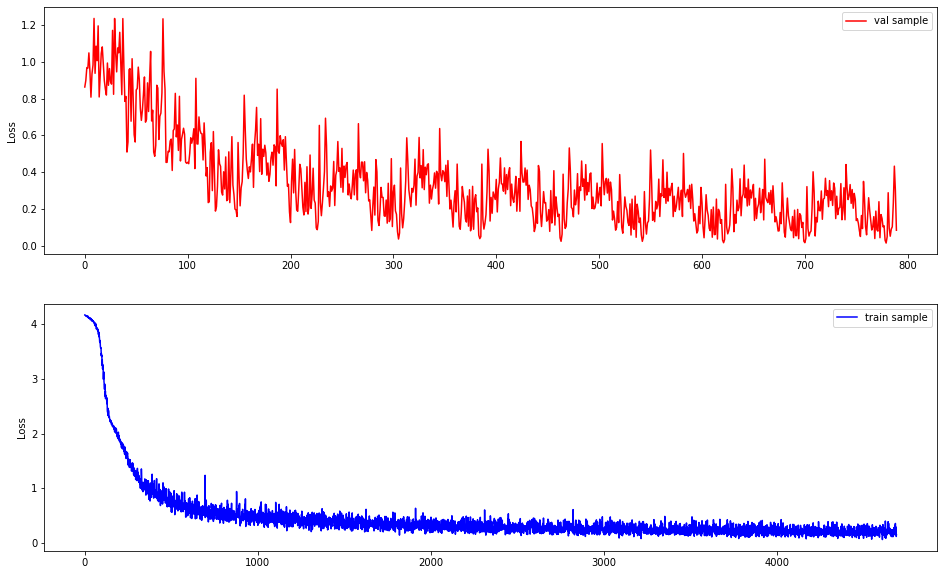

In [12]:
model = CustomCNN()
opt = optim.SGD(model.parameters(), lr=1e-2)
trainer = Trainer(model, opt, trainset, valset, batch_size=128)

trainer.train(10)

trainer.plot()

## Задание 4
**(0.3 балла)** Напишите класс CNN сети из 3 блоков с добавлением skip-connection блока
(ResNet [paper](https://arxiv.org/abs/1512.03385)).  
**(0.2 балла, бонус)** Реализовать residual блок в отдельном классе `ResBlock`.

*Hint 1:* на вход все те же батчи размера [BS, C, H, W]  
*Hint 2:* пример skip-connection:  
![image](https://i1.wp.com/dangminhthang.com/wp-content/uploads/2020/06/resnet-block.jpg?fit=400%2C225)

In [13]:
class ResBlock(nn.Module):
    def __init__(self, int_out): # по идее потом, чтобы плюсоваться с х, мы должна всегда подавать и забирать одинаковое число каналов
        super(ResBlock, self).__init__()

        self.inner = nn.Sequential(
            nn.Conv2d(int_out, int_out*2, kernel_size=3, padding=1), # пусть количество скрытых слоев всегда больше количества слоев вхождения в два раза
            nn.ReLU(),
            nn.Conv2d(int_out*2, int_out, kernel_size=3, padding=1) # ну и обратно возвращаем наше количество каналов
        )

        self.relu = nn.ReLU() # потом чтобы применить к сумме identity и F(x)
        
    def forward(self, x):
        return self.relu(self.inner(x) + x )
    
    def compute_all(self, batch):
        x = batch['sample']
        y = batch['label']
        logits = self.forward(x)
        
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)
        return loss, metrics


class CustomResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.inner = nn.Sequential(nn.Conv2d(1, 2, kernel_size=3), # увеличиваем чисто каналов, чтобы в РесБлок подать больше, чем один
                                   ResBlock(2), # собсна наш РесБлок
                                   nn.MaxPool2d(2), # по классике начинаем новый слой с макспулла
                                   nn.Conv2d(2, 16, kernel_size=3), # еще раз увеличим число каналов
                                   ResBlock(16), 
                                   nn.MaxPool2d(2),
                                   nn.Conv2d(16, 64, kernel_size=2),
                                   ResBlock(64),
                                   nn.Flatten()) # вытягиваем                  
               
    def forward(self, x):
        return self.inner(x)
    
    def compute_all(self, batch):
        x = batch['sample'].reshape(-1, 1, 28, 28) # [bs, c, h, w]
        y = batch['label']
        logits = self.forward(x)
        
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)
        return loss, metrics

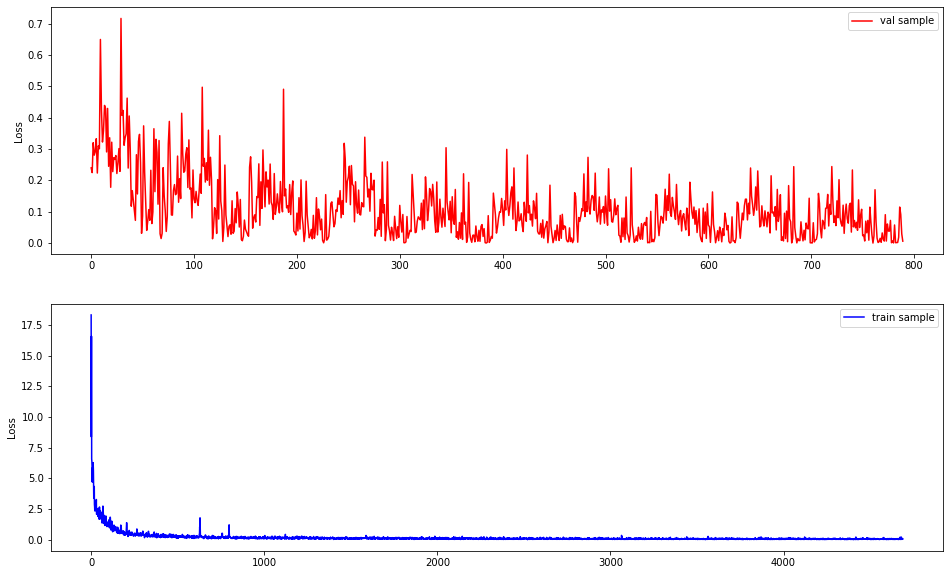

In [14]:
model = CustomResNet()
opt = optim.SGD(model.parameters(), lr=1e-2)
trainer = Trainer(model, opt, trainset, valset, batch_size=128)

trainer.train(10)

trainer.plot()

## Задание 5
**(0.1 балла)** Инициализируйте и обучите сети из пунктов 1, 2, 3, используя класс `Trainer` из семинара.

_Я делал это сразу, иначе как понять, что все работает)))_